# Beat Tracking

## Imports

In [99]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np

from scipy.signal import medfilt as medfilt
from scipy.ndimage import maximum_filter1d as maxfilt

## Loading file

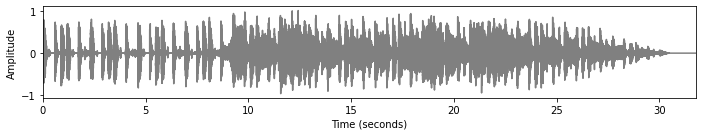

In [24]:
path_data = '../ballroom-data/'

# For now just testing with one
audio_file = path_data+'/Rumba-International/Media-105611.wav'
ipd.display(ipd.Audio(os.path.join(audio_file)))

# Load audio
x, sr = librosa.load(os.path.join(audio_file))  # sampled at a rate of 22050 Hz

# Plot audio
t1 = np.arange(x.shape[0]) / sr
plt.figure(figsize=(10, 2))
plt.plot(t1, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t1[0], t1[-1]])
plt.tight_layout()

## Onset Detection

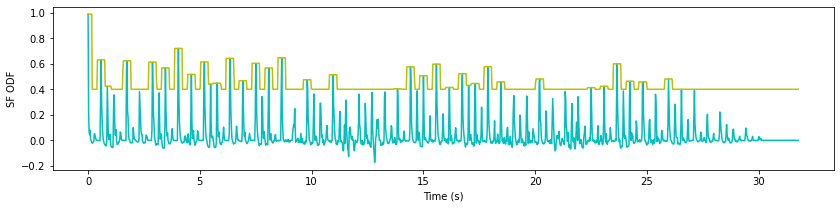

In [150]:
n = 2048
window = 'hann'
hop_length = 512

def detect_onsets(x, width=15, threshold=0.4):
    # Short Fast Fourier Transform for spectrogram of audio
    D = np.abs(librosa.stft(x, n_fft=n, window=window, hop_length=hop_length))  # STFT
    D_transp = D.transpose()
    
    # Initialise variables for iterating
    frames = len(D_transp)
    odf = np.zeros(frames)  # stores odf energy values for insinuating onsets
    bins = len(D)
    prev_magnitude = np.zeros(bins)  # stores magnitude of previous frame
    
    # Iterate through frames, process data via spectral flux
    for i, frame in enumerate(D_transp):
        magnitude = np.abs(frame)
        
        has_greater_magnitude = np.greater(magnitude, prev_magnitude)
        diff_magnitude = np.subtract(magnitude, prev_magnitude)
        
        spectral_flux = np.mean(np.multiply(has_greater_magnitude, diff_magnitude))
        odf[i] = spectral_flux
        
        prev_magnitude = magnitude
        
    # Normalise with respect to maximum odf value
    mx = max(odf)
    if mx > 0: odf /= mx
        
    # Peak picking, filtering and thresholding on odf for times of each onset
    hop_time = hop_length / sr
    t = np.arange(len(odf)) * hop_time
    odf_med = odf - medfilt(odf, width)
    odf_max = maxfilt(odf_med, width, mode='nearest', axis=0)
    
    thresholds = [max(i, threshold) for i in odf_max]
    peak_args = np.nonzero(np.greater_equal(odf_med, thresholds))
    peak_times = peak_args[0] * hop_time
    
    plt.figure(figsize=(14, 3))
    plt.xlabel('Time (s)')
    plt.ylabel('SF ODF')
    plt.plot(t, odf_med, 'c')
    plt.plot(t, thresholds, 'y')
    
    return peak_times
    
detect_onsets(x)

## IOI Histogram

## Periodicity function

## Prediction

## Results